# Yield Analysis Notebook

This notebook demonstrates how SHAP-based feature selection improves model performance.

### Performance Improvement

| Model Version | R² Score | MAE |
|--------------|----------|-----|
| Full feature set | **0.9062** | **0.2389** |
| SHAP-reduced features | **0.9609** | **0.1318** |

**Key insight:**  
Using SHAP to remove low-impact features leads to a simpler model with significantly better accuracy and lower error.

---

## Workflow Overview

### 1. Load Data
- Read dataset from Excel
- Create working copy

### 2. Exploratory Data Analysis (EDA)
- Histogram plots for numerical features
- Correlation heatmap
- Individual feature vs yield visuals

### 3. Preprocessing
- One-hot encode categorical variables
- Train–test split

### 4. Modeling
- Fit XGBoost


In [1]:
# ===========================
# a) READ DATA
# ===========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from xgboost import XGBRegressor
import shap

# change this if your target column name is different
TARGET_COL = "Yield"

# read excel data
df_raw = pd.read_excel("data.xlsx")  # or full path if needed
df = df_raw.copy()

/Users/utkarshpratiush/project/just-learning/Yield_Minimal_feature/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df.shape

(73114, 54)

(73114, 54)
   year      state district        Crop   Area  Production     Yield     Zn  \
0  2015  Karnataka   Mysore     Sorghum  16.66       12.76  0.765906  52.25   
1  2015  Karnataka   Mysore   Sugarcane   9.16       87.47  9.549127  52.25   
2  2015  Karnataka   Mysore   Sunflower   9.85        3.38  0.343147  52.25   
3  2015  Karnataka   Mysore  Vegetables  16.70       10.27  0.768786  52.25   
4  2016  Karnataka   Mysore      Castor   1.16        0.22  0.189655  52.25   

      Fe    Cu  ...  temp_min  temp_avg  state_key  district_key  year_key  \
0  42.12  93.5  ...    17.900    25.688  karnataka        mysore      2015   
1  42.12  93.5  ...    17.900    25.688  karnataka        mysore      2015   
2  42.12  93.5  ...    17.900    25.688  karnataka        mysore      2015   
3  42.12  93.5  ...    17.900    25.688  karnataka        mysore      2015   
4  42.12  93.5  ...    17.944    25.615  karnataka        mysore      2016   

   ndvi_lag1  evi_lag1 ndvi_roll3  evi_roll3

<Figure size 1200x800 with 0 Axes>

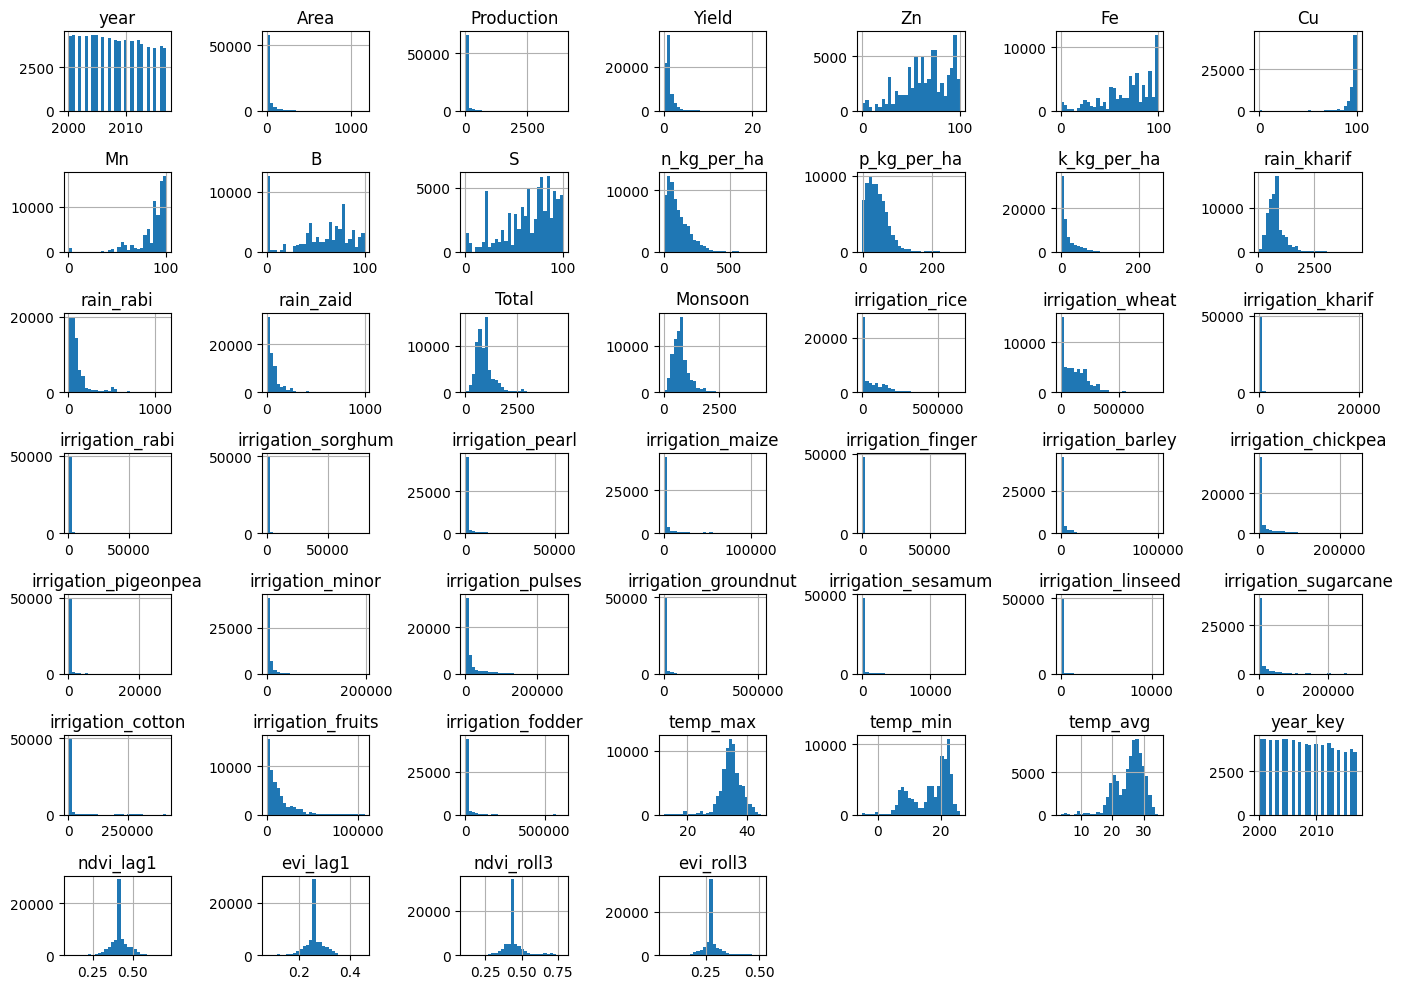

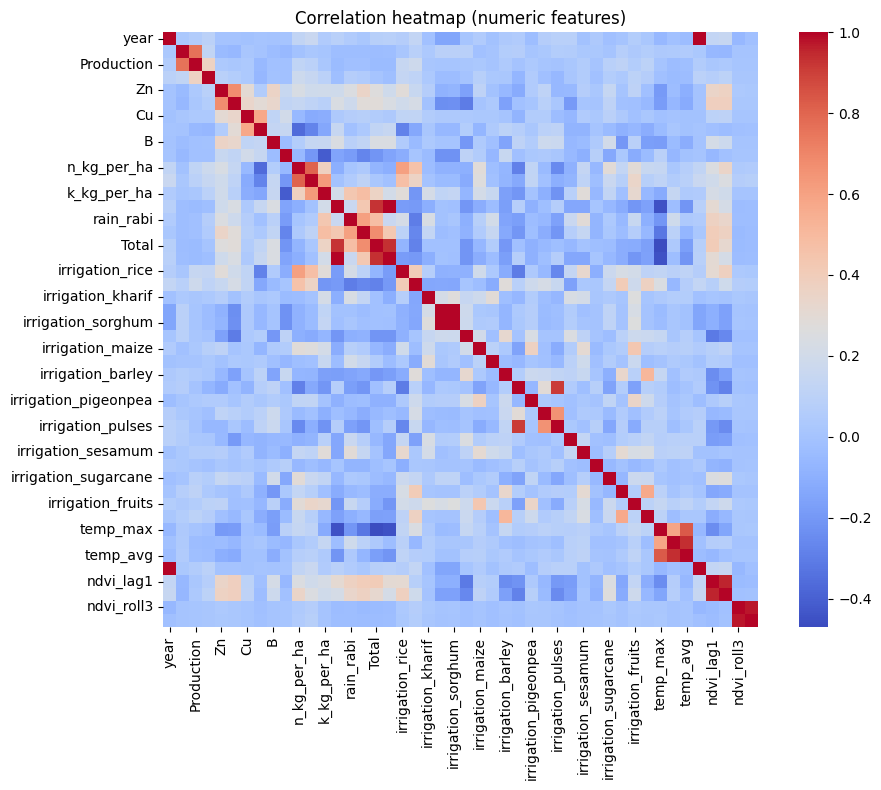

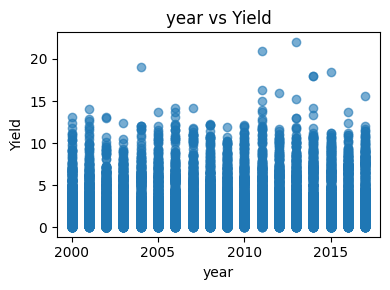

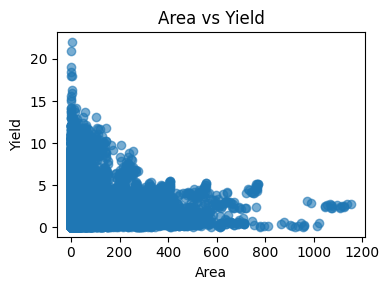

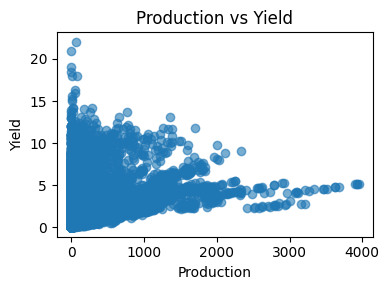

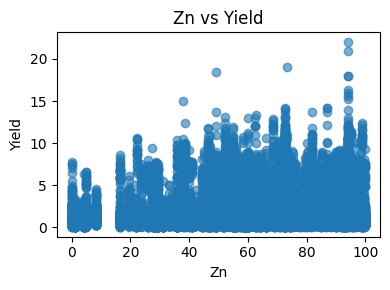

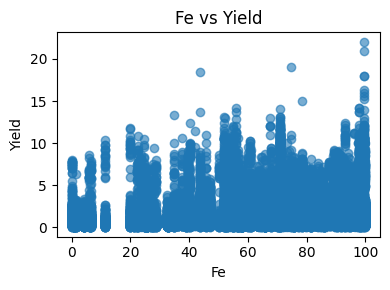

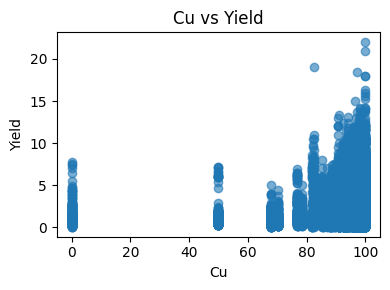

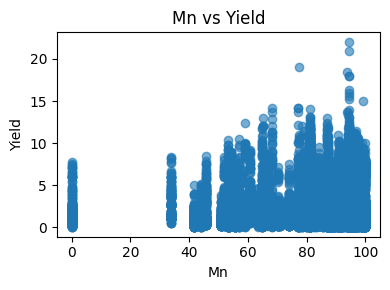

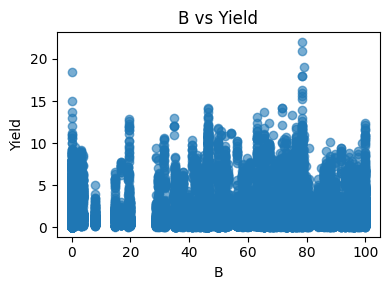

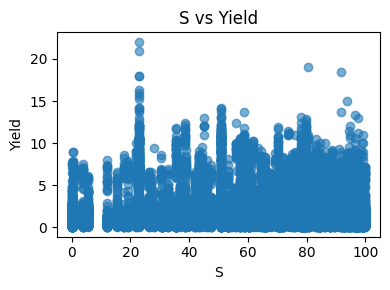

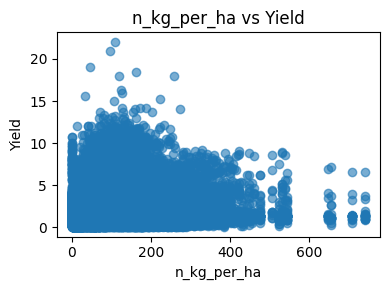

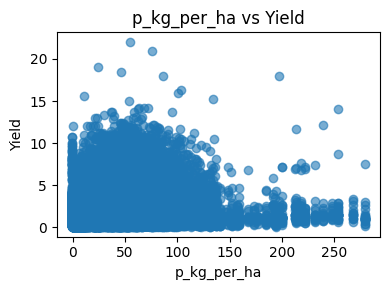

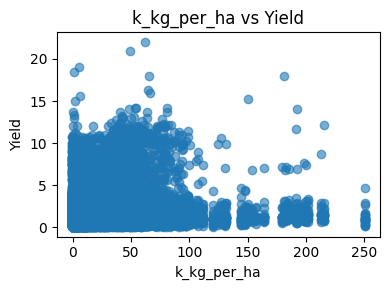

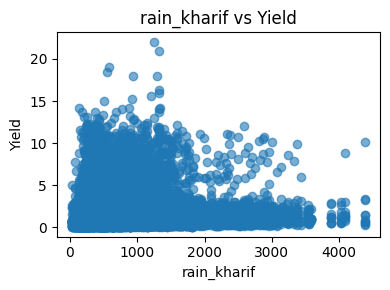

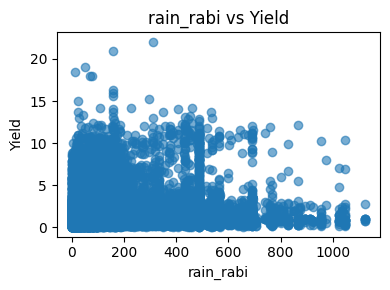

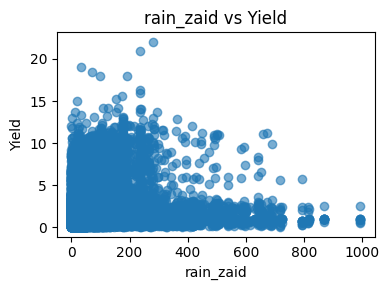

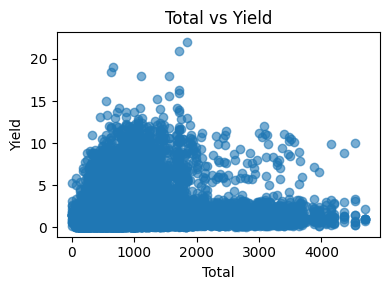

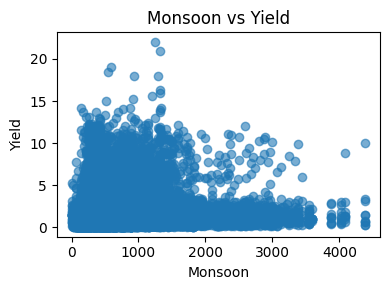

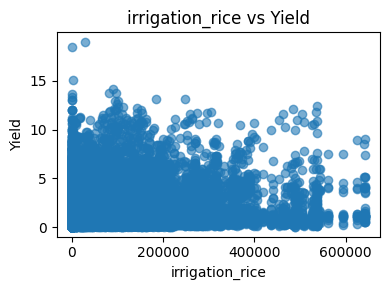

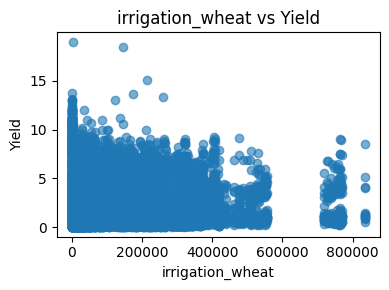

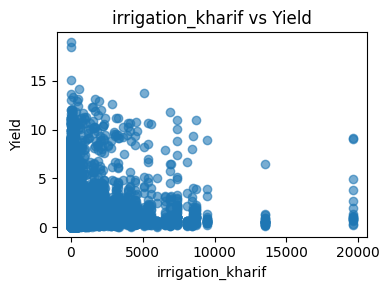

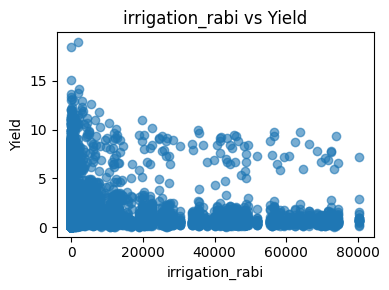

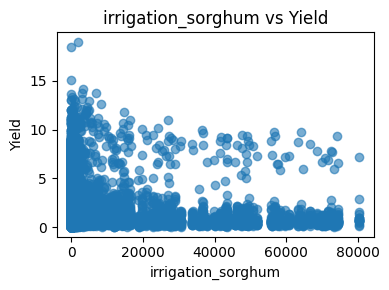

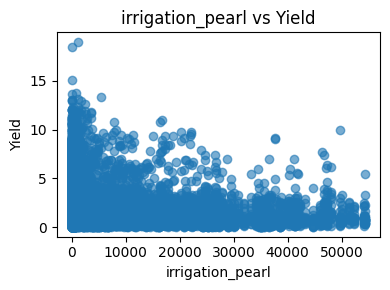

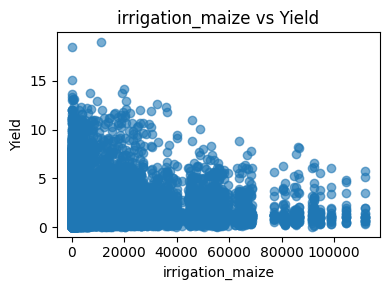

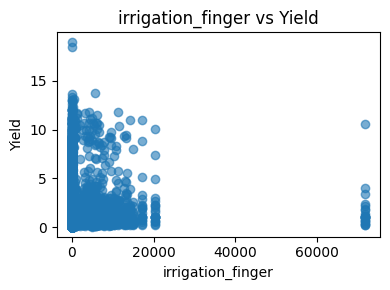

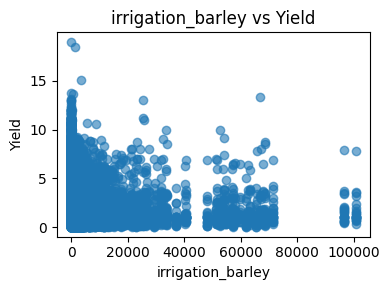

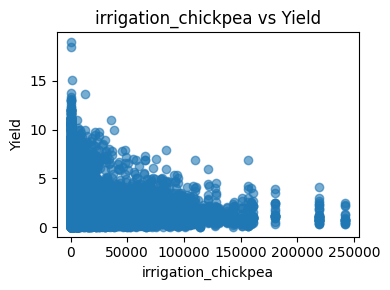

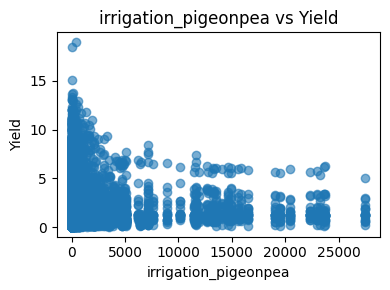

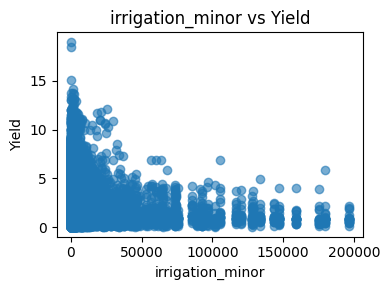

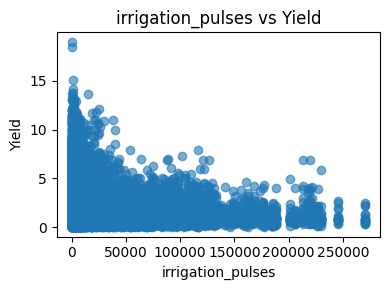

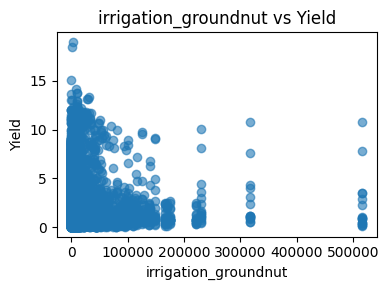

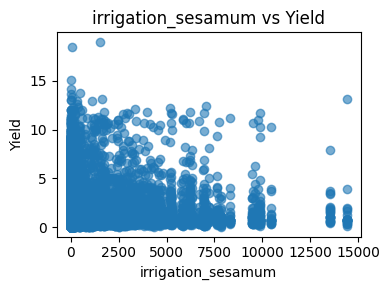

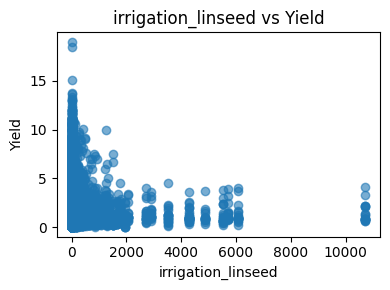

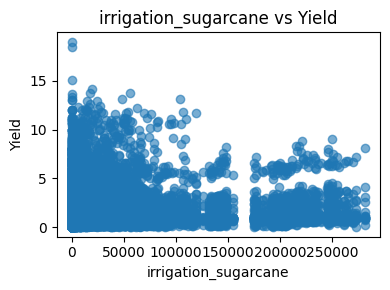

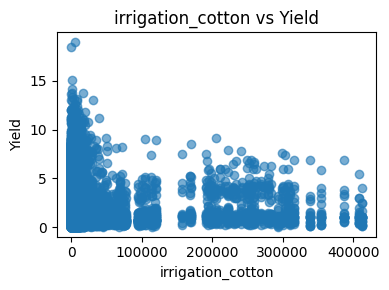

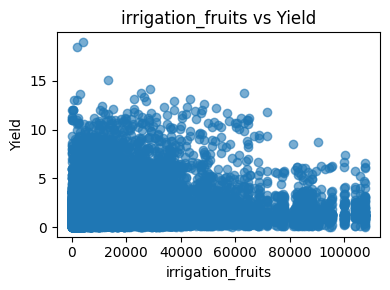

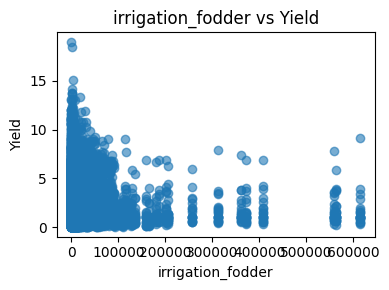

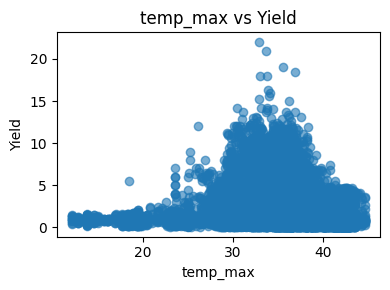

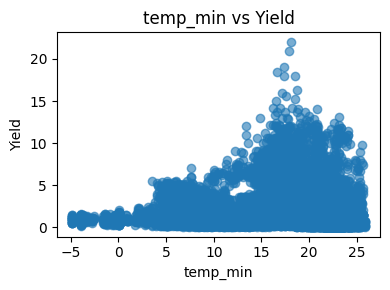

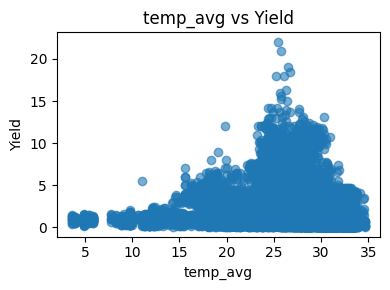

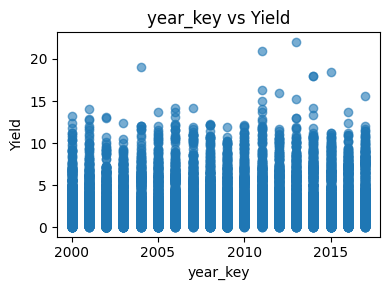

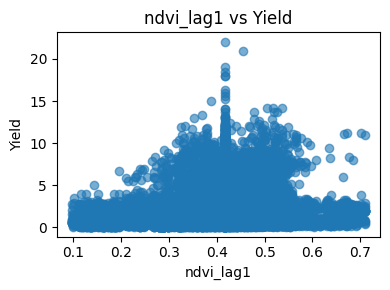

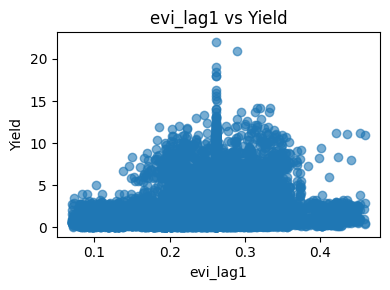

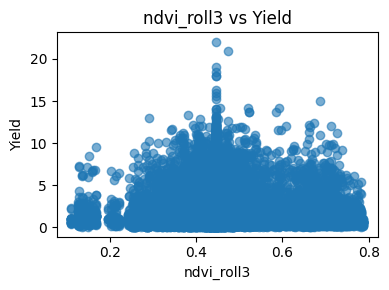

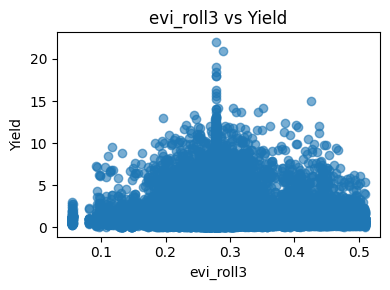

In [3]:
# ===========================
# b) BASIC EDA
# ===========================

# quick preview
print(df.shape)
print(df.head())

# info and summary
print(df.info())
print(df.describe(include="all"))

# check missing values
print(df.isna().sum().sort_values(ascending=False))

# select numeric columns
num_cols = df.select_dtypes(include=np.number).columns.tolist()

# histogram of numeric features
plt.figure(figsize=(12, 8))
df[num_cols].hist(figsize=(14, 10), bins=30)
plt.tight_layout()
plt.show()

# correlation matrix for numeric features
plt.figure(figsize=(10, 8))
corr = df[num_cols].corr()
sns.heatmap(corr, annot=False, cmap="coolwarm", square=True)
plt.title("Correlation heatmap (numeric features)")
plt.tight_layout()
plt.show()

# scatter plots of each numeric feature vs target (if numeric)
if TARGET_COL in num_cols:
    for col in num_cols:
        if col == TARGET_COL:
            continue
        plt.figure(figsize=(4, 3))
        plt.scatter(df[col], df[TARGET_COL], alpha=0.6)
        plt.xlabel(col)
        plt.ylabel(TARGET_COL)
        plt.title(f"{col} vs {TARGET_COL}")
        plt.tight_layout()
        plt.show()

In [4]:
# ===========================
# c) XGBOOST MODEL ON YIELD
# ===========================

# drop rows with missing target
df = df.dropna(subset=[TARGET_COL])

# separate features and target
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

# basic preprocessing: one-hot encode categoricals
X = pd.get_dummies(X, drop_first=True)

# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# define and fit XGBoost model
xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

# evaluate
y_pred = xgb_model.predict(X_test)
print("R2:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

R2: 0.9061986735725629
MAE: 0.2389181277213609


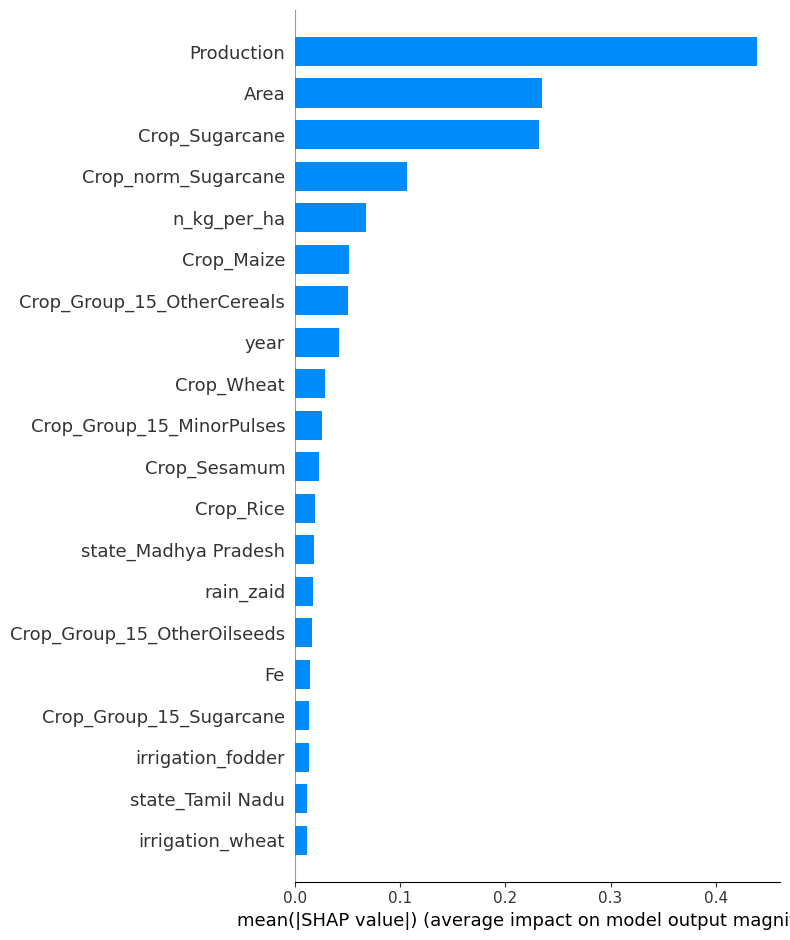

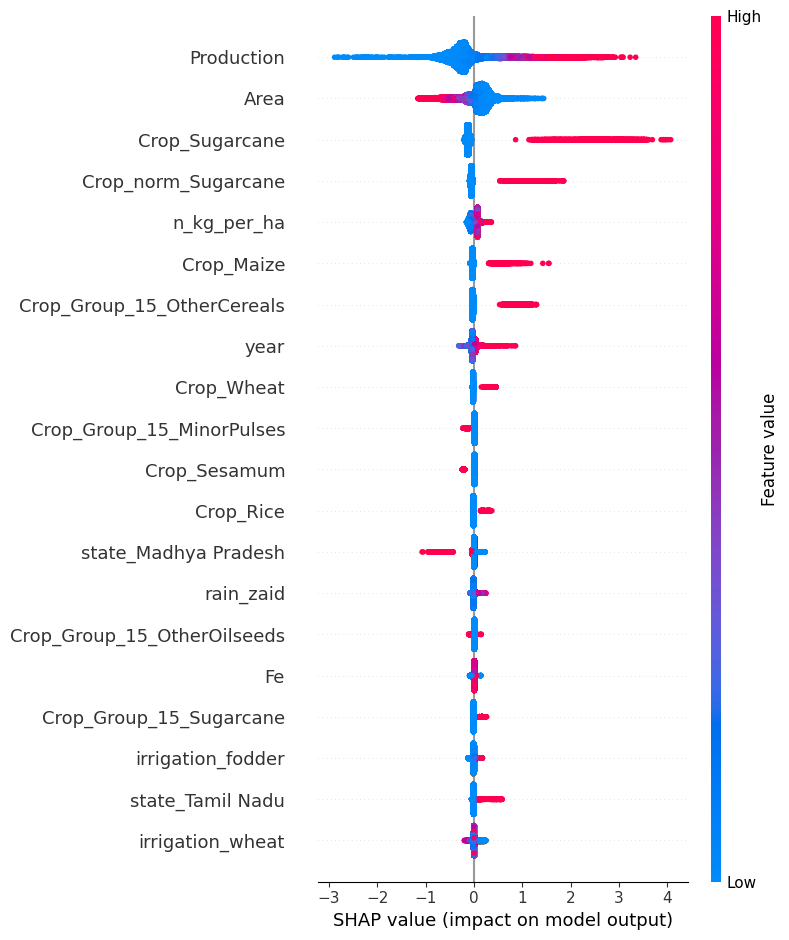

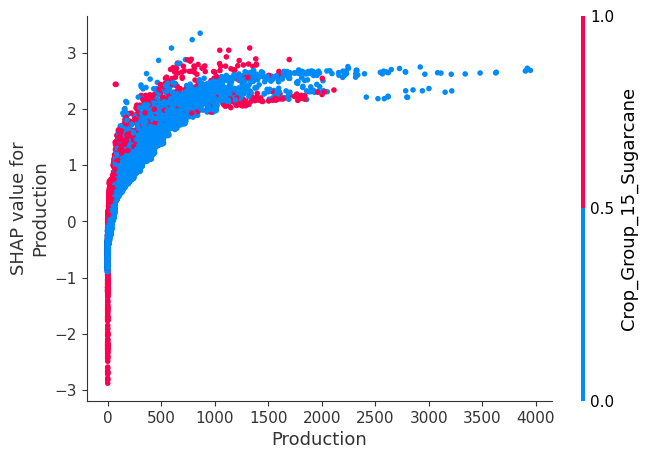

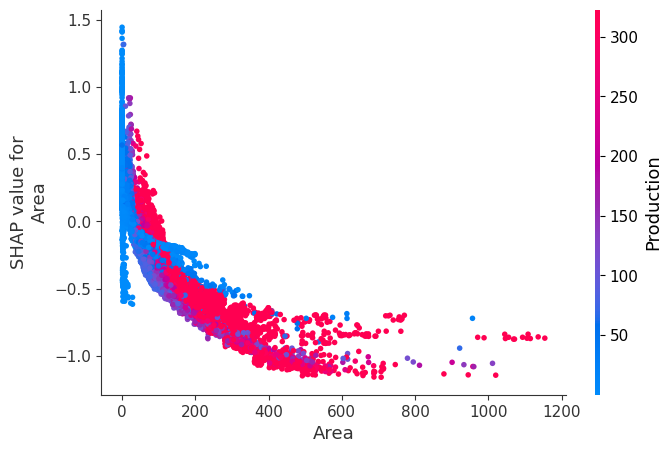

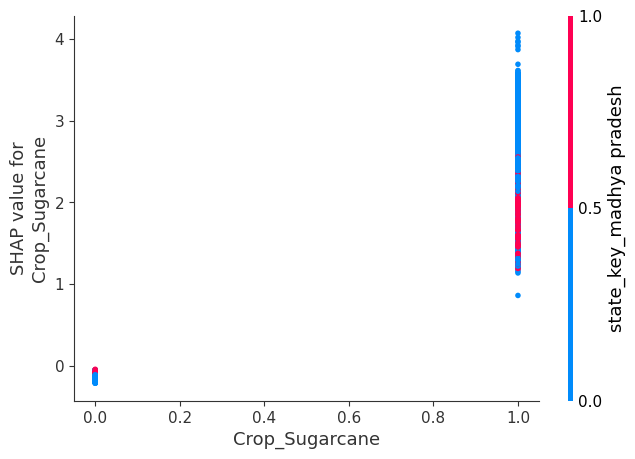

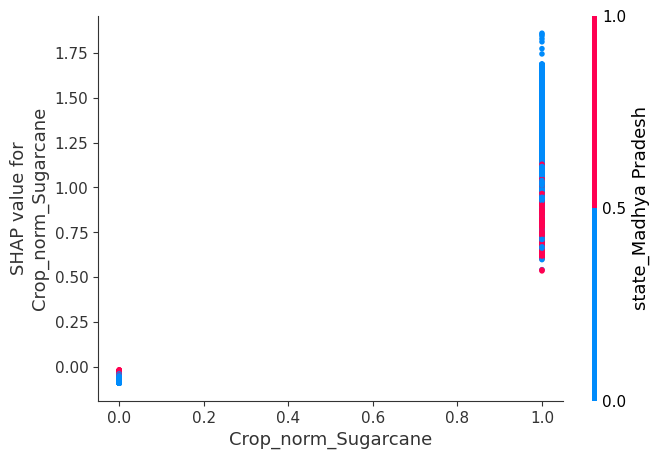

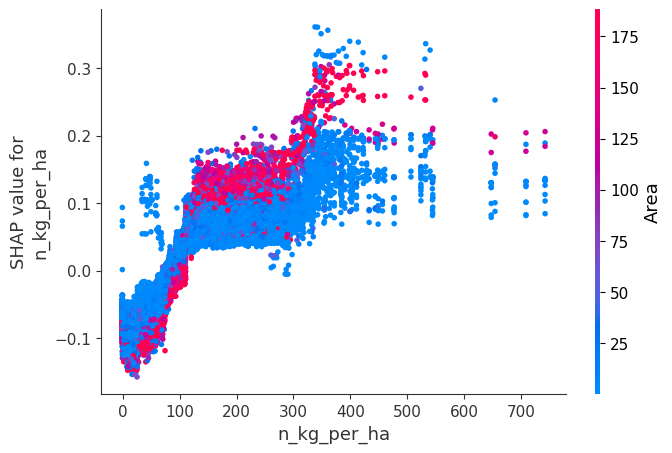

In [5]:
# ===========================
# d) SHAP FEATURE IMPORTANCE
# ===========================

# init shap
shap.initjs()

# tree explainer
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)

# bar plot of mean |SHAP| values (global feature importance)
shap.summary_plot(shap_values, X_train, plot_type="bar")

# detailed SHAP summary plot
shap.summary_plot(shap_values, X_train)

# optional: SHAP dependence plot for top features
# pick top k features by mean |SHAP|
abs_mean_shap = np.abs(shap_values).mean(axis=0)
feature_order = np.argsort(abs_mean_shap)[::-1]
top_features = X_train.columns[feature_order][:5]

for f in top_features:
    shap.dependence_plot(f, shap_values, X_train)

## choose important features in SHAP

In [6]:
import numpy as np
import pandas as pd

abs_mean_shap = np.abs(shap_values).mean(axis=0)
shap_importance = pd.Series(abs_mean_shap, index=X_train.columns)

shap_importance = shap_importance.sort_values(ascending=False)
print(shap_importance)


Production             0.439092
Area                   0.235118
Crop_Sugarcane         0.232311
Crop_norm_Sugarcane    0.106776
n_kg_per_ha            0.067393
                         ...   
district_Sultanpur     0.000000
district_Solapur       0.000000
district_Sirohi        0.000000
district_Sikar         0.000000
Crop_norm_Safflower    0.000000
Length: 569, dtype: float32


In [7]:
top_features = shap_importance.head(10).index


In [8]:
cum = shap_importance.cumsum() / shap_importance.sum()
top_features = cum[cum <= 0.95].index


In [9]:
X_train_red = X_train[top_features]
X_test_red  = X_test[top_features]


In [10]:
xgb_reduced = XGBRegressor(random_state=42)
xgb_reduced.fit(X_train_red, y_train)

y_pred_red = xgb_reduced.predict(X_test_red)

print("Reduced R2:", r2_score(y_test, y_pred_red))
print("Reduced MAE:", mean_absolute_error(y_test, y_pred_red))


Reduced R2: 0.9609596608072931
Reduced MAE: 0.13177198697455486


# Why R² improved after SHAP-based feature reduction

You removed features that were adding noise, not information
Low-impact features were making the model chase random variation.

The model became simpler and more stable
With fewer inputs, XGBoost stopped creating unnecessary splits.

Generalization improved on unseen data
Less overfitting → better performance on the test set.

SHAP kept only features that truly affect predictions
Unlike raw feature_importances, SHAP reflects real influence on model output.

Your dataset is not large, so extra features were harmful
Too many one-hot variables + limited samples = high variance.

Dropping weak features reduced variance more than it increased bias
This shift naturally raises R² on the test set.